In [7]:
import pandas
import fitz
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Data Preprocessing

### Converting the PDF to images

first we need to convert the pdf files into images to process them

Some pages of the pdf contain 2 pages in a single page so we need to split them

![image.png](attachment:image.png)

In [ ]:
from utils import pdf_to_images

In [ ]:
pdf_to_images('data/1_raw/books/book1.pdf', 'data/2_splitted/books/book1')
pdf_to_images('data/1_raw/books/book2.pdf', 'data/2_splitted/books/book2')
pdf_to_images('data/1_raw/books/book3.pdf', 'data/2_splitted/books/book3')
pdf_to_images('data/1_raw/books/book4.pdf', 'data/2_splitted/books/book4')
pdf_to_images('data/1_raw/books/book5.pdf', 'data/2_splitted/books/book5')
pdf_to_images('data/1_raw/books/book6.pdf', 'data/2_splitted/books/book6')
pdf_to_images('data/1_raw/books/book7.pdf', 'data/2_splitted/books/book7')
pdf_to_images('data/1_raw/books/book8.pdf', 'data/2_splitted/books/book8')

Processing complete! Saved 31 images in 'data/2_splitted/books/book1'.
Processing complete! Saved 31 images in 'data/2_splitted/books/book2'.
Processing complete! Saved 16 images in 'data/2_splitted/books/book3'.
Processing complete! Saved 6 images in 'data/2_splitted/books/book4'.
Processing complete! Saved 11 images in 'data/2_splitted/books/book5'.
Processing complete! Saved 9 images in 'data/2_splitted/books/book6'.
Processing complete! Saved 9 images in 'data/2_splitted/books/book7'.
Processing complete! Saved 11 images in 'data/2_splitted/books/book8'.


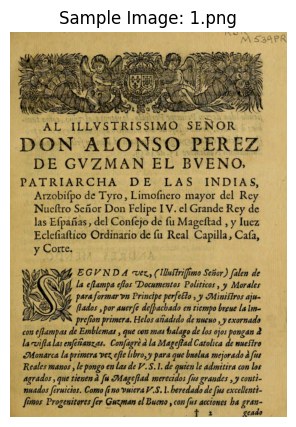

In [ ]:
from utils import display_sample
display_sample('data/2_splitted/books/book6/', sample_number=1)


### converting .docx transcript file to .txt files

In [ ]:
from utils import extract_text_by_page

for book in os.listdir("data/1_raw/transcripts"):
    docx_file = os.path.join("data/1_raw/transcripts", book)
    output_directory = os.path.join("data/2_splitted/transcripts", book.split(".")[0])
    extract_text_by_page(docx_file, output_directory)

Extracted 25 pages and saved them in 'data/2_splitted/transcripts\book1'.
Extracted 31 pages and saved them in 'data/2_splitted/transcripts\book2'.
Extracted 3 pages and saved them in 'data/2_splitted/transcripts\book3'.
Extracted 3 pages and saved them in 'data/2_splitted/transcripts\book4'.
Extracted 3 pages and saved them in 'data/2_splitted/transcripts\book5'.
Extracted 5 pages and saved them in 'data/2_splitted/transcripts\book6'.
Extracted 3 pages and saved them in 'data/2_splitted/transcripts\book7'.
Extracted 3 pages and saved them in 'data/2_splitted/transcripts\book8'.


### Preprocessing Images

Resizing images based on aspect ratio and addin gpadding to convert them into 1024x1536 size for stable diffusion model


In [1]:
from utils import (load_image, correct_skew, normalize_image, ensure_300ppi, remove_bleed_dual_layer, denoise_image, sharpen_image, enhance_contrast, morphological_operations, binarize_image, apply_binary_mask, add_fixed_padding)

def transform_images( image_path, output_path=None):
    results = {}

    image = load_image(image_path)
    results['original'] = image.copy()

    deskewed = correct_skew(image)
    results['deskewed'] = deskewed.copy()

    normalized = normalize_image(deskewed)
    results['normalized'] = normalized.copy()

    scaled = ensure_300ppi(normalized)
    results['scaled'] = scaled.copy()

    ink_bleed = remove_bleed_dual_layer(scaled)
    results['ink_bleed'] = ink_bleed.copy()

    denoised = denoise_image(ink_bleed, method="wiener")
    denoised = denoise_image(denoised, method="bilateral")
    denoised = denoise_image(denoised, method="nlm")
    results['denoised'] = denoised.copy()

    sharpened = sharpen_image(denoised, method="unsharp_mask")
    results['sharpened'] = sharpened.copy()

    enhanced = enhance_contrast(sharpened, method='laplacian')
    results['enhanced'] = enhanced.copy()

    morph = morphological_operations(enhanced, operation="close", kernel_size=(5,5), iterations=1)
    results['morph'] = morph.copy()

    binary_mask = binarize_image(morph, method="otsu")
    binary = apply_binary_mask(morph,binary_mask)
    results['binary'] = binary.copy()

    final = add_fixed_padding(binary)
    results['final(padded)'] = final.copy()

    if output_path:
        os.makedirs(output_path, exist_ok=True)
        cv2.imwrite(output_path, final)

    return results

In [2]:
import os
import cv2
import shutil
from pathlib import Path

def process_books(input_dir, output_dir, transform_images):
    """Process all book images and save transformed versions."""

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through each book directory
    for book in os.listdir(input_dir):
        book_path = os.path.join(input_dir, book)

        # Skip if not a directory
        if not os.path.isdir(book_path):
            continue

        print(f"Processing book: {book}")

        # Process each image in the book
        for image_name in os.listdir(book_path):
            # Skip non-image files
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            # Extract page number from filename
            page_number = image_name.split('.')[0]
            image_path = os.path.join(book_path, image_name)

            # Define output path
            output_image_path = os.path.join(output_dir, f"{book}_{page_number}.png")

            try:
                # Apply transformation
                transformed_result = transform_images(image_path)
                final_image = transformed_result['final(padded)']

                # Save transformed image (convert RGB to BGR for OpenCV)
                cv2.imwrite(output_image_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

            except Exception as e:
                print(f"  Error processing {image_name}: {str(e)}")

In [ ]:
# Run the processing function
input_dir = "data/2_splitted/books"
output_dir = "data/3_transformed/images"

# Assuming transform_images function is already defined
process_books(input_dir, output_dir, transform_images)

### Normalizing text

Based on the rules provided in the word files modifying the transcripts

In [ ]:
from utils import normalize_text_file

In [ ]:
input_root = "data/2_splitted/transcripts"
output_root = "data/3_transformed/transcripts"
os.makedirs(output_root, exist_ok=True)

for book in os.listdir(input_root):
    book_dir = os.path.join(input_root, book)
    for page in os.listdir(book_dir):
        page_no = int(page.split("_")[1].split(".")[0])
        if page.lower().endswith(".txt"):
            input_path = os.path.join(book_dir, page)
            normalize_text_file(
                input_path= input_path,
                output_path= os.path.join(output_root, f"{book}_{page_no}.txt")
                )

### Seperating 5 page images for testing

In [ ]:
import os
import random
import shutil
from pathlib import Path

def select_random_pairs(image_dir, transcript_dir, test_image_dir, test_transcript_dir, num_pairs=5):
    # Create test directories if they don't exist
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_transcript_dir, exist_ok=True)

    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    # Get basenames of all images
    image_basenames = [os.path.splitext(f)[0] for f in image_files]

    # Get all transcript files
    transcript_files = [f for f in os.listdir(transcript_dir) if os.path.isfile(os.path.join(transcript_dir, f))]

    # Get basenames of all transcripts
    transcript_basenames = [os.path.splitext(f)[0] for f in transcript_files]

    # Randomly select pairs
    selected_basenames = random.sample(transcript_basenames, num_pairs)

    moved_pairs = 0

    # Move the selected pairs to test directories
    for basename in selected_basenames:
        # Find the corresponding image file
        image_file = next((f for f in image_files if os.path.splitext(f)[0] == basename), None)
        transcript_file = next((f for f in transcript_files if os.path.splitext(f)[0] == basename), None)

        # Get full paths
        image_path = os.path.join(image_dir, image_file)
        transcript_path = os.path.join(transcript_dir, transcript_file)
        test_image_path = os.path.join(test_image_dir, image_file)
        test_transcript_path = os.path.join(test_transcript_dir, transcript_file)

        shutil.move(image_path, test_image_path)
        shutil.move(transcript_path, test_transcript_path)
        moved_pairs += 1
        print(f"Moved pair {basename} to test directories")


In [ ]:
image_directory = "data/3_transformed/images"
transcript_directory = "data/3_transformed/transcripts"
test_image_directory = "data/test/images"
test_transcript_directory = "data/test/transcripts"
select_random_pairs(
    image_directory,
    transcript_directory,
    test_image_directory,
    test_transcript_directory,
    num_pairs=5
)

Moved pair book2_22 to test directories
Moved pair book2_17 to test directories
Moved pair book6_2 to test directories
Moved pair book6_4 to test directories
Moved pair book7_3 to test directories


### Getting Bounding Boxes

In [ ]:
import os

input_root = "data/3_transformed/images"
transcripts_root = "data/3_transformed/transcripts"
output_root = "data/4_bounding_boxes//"

os.makedirs(output_root, exist_ok=True)

!python CRAFT-pytorch/test.py \
--trained_model=CRAFT-pytorch/weights/craft_mlt_25k.pth \
--result_folder={output_root} \
--test_folder={input_root} \
--text_threshold=0.8 \
--low_text=0.33 \
--link_threshold=0.5 \
--mag_ratio=1.2 \
--canvas_size=1800 \
--refiner_model=CRAFT-pytorch/weights/craft_refiner_CTW1500.pth \
--cuda=True


c:\Users\sarth\anaconda3\envs\imageGeneration\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarth\anaconda3\envs\imageGeneration\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


###  Mapping the Bounding Boxes with the transcript words

In [ ]:
from utils import process_all_files

In [ ]:
process_all_files(
    image_dir="data/3_transformed/images",
    bbox_dir="data/4_bounding_boxes",
    transcript_dir="data/3_transformed/transcripts",
    output_dir="data/5_mapped",
    tesseract_model=1,
    similarity_threshold=0.8
)

Processing files in data/3_transformed/images...
File book1_1: Found 82 words in transcript file, mapped 47 of 79 bounding boxes
File book1_10: Found 157 words in transcript file, mapped 81 of 138 bounding boxes
File book1_11: Found 166 words in transcript file, mapped 107 of 154 bounding boxes
File book1_12: Found 143 words in transcript file, mapped 75 of 129 bounding boxes
File book1_13: Found 158 words in transcript file, mapped 74 of 143 bounding boxes
File book1_14: Found 140 words in transcript file, mapped 94 of 131 bounding boxes
File book1_15: Found 110 words in transcript file, mapped 69 of 104 bounding boxes
File book1_16: Found 149 words in transcript file, mapped 92 of 143 bounding boxes
File book1_17: Found 147 words in transcript file, mapped 87 of 139 bounding boxes
File book1_18: Found 139 words in transcript file, mapped 75 of 127 bounding boxes
File book1_19: Found 151 words in transcript file, mapped 89 of 141 bounding boxes
File book1_2: Found 158 words in transcr

### Extracting and saving detected regions

In [ ]:
import pandas as pd
import os
from utils import extract_and_save_regions

image_root = "data/3_transformed/images"
aligned_root = "data/5_mapped"
output_root = "data/6_word_data/images"
os.makedirs(output_root, exist_ok=True)

df_records = []
global_index = 0

for image in os.listdir(aligned_root):
    image_path = os.path.join(image_root, image.replace("_mapped.txt", ".png"))
    aligned_path = os.path.join(aligned_root, image)

    results, global_index = extract_and_save_regions(image_path, aligned_path, output_root, global_index)
    df_records.extend(results)

df = pd.DataFrame(df_records, columns=["Image", "label"])

df.to_csv("data/6_word_data/words.csv", index=False)

In [ ]:
df.head()

,Image,label
0,image0.png,noble
1,image1.png,fortaleza
2,image2.png,la
3,image3.png,propia
4,image4.png,que


### Augmenting Data

In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import shutil
import warnings
warnings.filterwarnings("ignore")

def create_augmentation_pipeline():
    return A.Compose([
        # Subtle Geometric Transformations to simulate page curvature/scanning imperfections
        A.OneOf([
            A.Affine(scale=(0.98, 1.02), translate_percent=0.005, rotate=(-1, 1), shear=(-0.3, 0.3), p=0.6),
            A.ShiftScaleRotate(shift_limit=0.005, scale_limit=0.01, rotate_limit=1, border_mode=0, p=0.4),
        ], p=0.7),

        # Subtle Brightness/Contrast variations mimicking page aging and lighting conditions
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.07, p=0.5),
            A.RandomGamma(gamma_limit=(90, 110), p=0.4),
            # Subtle sepia effect to simulate aged paper
            A.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.03, hue=0.01, p=0.3),
        ], p=0.7),

        # Historical document specific degradations
        A.OneOf([
            # Simulate ink bleeding or fading
            A.GaussianBlur(blur_limit=(1, 2), p=0.4),
            # Simulate paper texture
            A.MultiplicativeNoise(multiplier=(0.95, 1.05), per_channel=False, p=0.5),
            # Simulate minor scan artifacts
            A.ImageCompression(quality_lower=85, quality_upper=98, p=0.3),
            # Simulate ink spots or small stains
            A.CoarseDropout(max_holes=3, max_height=3, max_width=3, min_holes=1, min_height=1, min_width=1, p=0.3),
        ], p=0.6),

        # Subtle shadows and uneven illumination common in book scans
        A.OneOf([
            A.RandomShadow(num_shadows=1, shadow_dimension=3, shadow_roi=(0, 0, 1, 0.2), p=0.3),
            A.RandomShadow(num_shadows=1, shadow_dimension=3, shadow_roi=(0, 0.8, 1, 1), p=0.3),
            # Vignetting effect often seen in older scans
            A.RandomBrightnessContrast(brightness_limit=(-0.03, 0), contrast_limit=0, p=0.2),
        ], p=0.4),

        # Occasional paper texture and grain
        A.OneOf([
            # Add subtle noise to simulate paper grain
            A.GaussNoise(var_limit=(2, 8), p=0.5),
            # Simulate minor page foxing (age spots)
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.05, 0.1), p=0.3),
        ], p=0.5),
    ])

In [ ]:
## Function to apply augmentation to all the word images
def augment_dataset(input_dir, df_path, output_dir, augmentations_per_image=5):

    os.makedirs(output_dir, exist_ok=True)

    df = pd.read_csv(df_path)
    print(f"Original dataset: {len(df)} images")

    # First, copy all original images to the output directory
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Copying original images"):
        img_path = os.path.join(input_dir, row['Image'])
        if os.path.exists(img_path):
            shutil.copy2(img_path, os.path.join(output_dir, row['Image']))
        else:
            print(f"Warning: Original image not found: {img_path}")

    transform = create_augmentation_pipeline()

    new_entries = []

    # Apply augmentations
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating augmentations"):
        image_path = os.path.join(input_dir, row['Image'])
        text = row['label']

        if not os.path.exists(image_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image {image_path}")
            continue

        for aug_idx in range(augmentations_per_image):
            aug_image = transform(image=image)['image']

            base_name, ext = os.path.splitext(row['Image'])
            aug_name = f"{base_name}_aug{aug_idx+1}{ext}"

            aug_path = os.path.join(output_dir, aug_name)
            cv2.imwrite(aug_path, aug_image)

            new_entries.append({
                'Image': aug_name,
                'label': text,
                'augmented': True
            })

    df['augmented'] = False

    aug_df = pd.DataFrame(new_entries)

    combined_df = pd.concat([df, aug_df], ignore_index=True)

    print(f"Augmentation completed: {len(combined_df)} total images")
    print(f"  - {len(df)} original images")
    print(f"  - {len(aug_df)} augmented images")

    return combined_df

In [ ]:
# Path to your dataset
input_dir = "data/6_word_data/images"
df_path = "data/6_word_data/words.csv"
output_dir = "data/7_augmented_data/images"

# Perform augmentation
augmented_df = augment_dataset(input_dir, df_path, output_dir, augmentations_per_image=5)
augmented_df.to_csv("data/7_augmented_data/augmented_words.csv", index=False)

Original dataset: 6396 images


Generating augmentations: 100%|██████████| 6396/6396 [01:32<00:00, 69.52it/s] 

Augmentation completed: 38376 total images
  - 6396 original images
  - 31980 augmented images


In [ ]:
augmented_df.head()

,Image,label,augmented
0,image0.png,noble,False
1,image1.png,fortaleza,False
2,image2.png,la,False
3,image3.png,propia,False
4,image4.png,que,False


In [ ]:
from utils import analyze_image_sizes

analyze_image_sizes("data/6_word_data/images")

Analyzed 6396 images in data/6_word_data/images
Dimensions (width x height):
  Minimum: 36 x 51 pixels
  Maximum: 1581 x 641 pixels
  Average: 228.6 x 108.7 pixels


### Padding/Resizing to a fixed size

In [ ]:
from utils import resize_and_pad

In [ ]:
target_height, target_width = 128,384  # Adjust based on your dataset
# Resize with aspect ratio preservation and pad

for image in os.listdir("data/7_augmented_data/images"):
    img = Image.open(f"data/7_augmented_data/images/{image}")
    processed_img = resize_and_pad(img, target_height, target_width, output_dir="data/8_padded/")

### Encoding Images

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from diffusers import AutoencoderKL
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transform for normalizing
normalize = transforms.Normalize([0.5], [0.5])

# Load the VAE
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
vae.eval()

# Process directory of images
image_dir = "data/8_padded"
latents_dir = "data/9_encoded/images"
os.makedirs(latents_dir, exist_ok=True)

with torch.no_grad():
    for img_file in os.listdir(image_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            img_path = os.path.join(image_dir, img_file)
            img = Image.open(img_path).convert("RGB")

            # Transform and encode
            img_tensor = normalize(transforms.ToTensor()(img)).unsqueeze(0).to(device)
            latent = vae.encode(img_tensor).latent_dist.sample()

            # Save latent
            torch.save(latent, os.path.join(latents_dir, f"{os.path.splitext(img_file)[0]}.pt"))

Processed: image3142_aug1.png
Processed: image2233.png
Processed: image6265.png
Processed: image4408.png
Processed: image2047_aug2.png


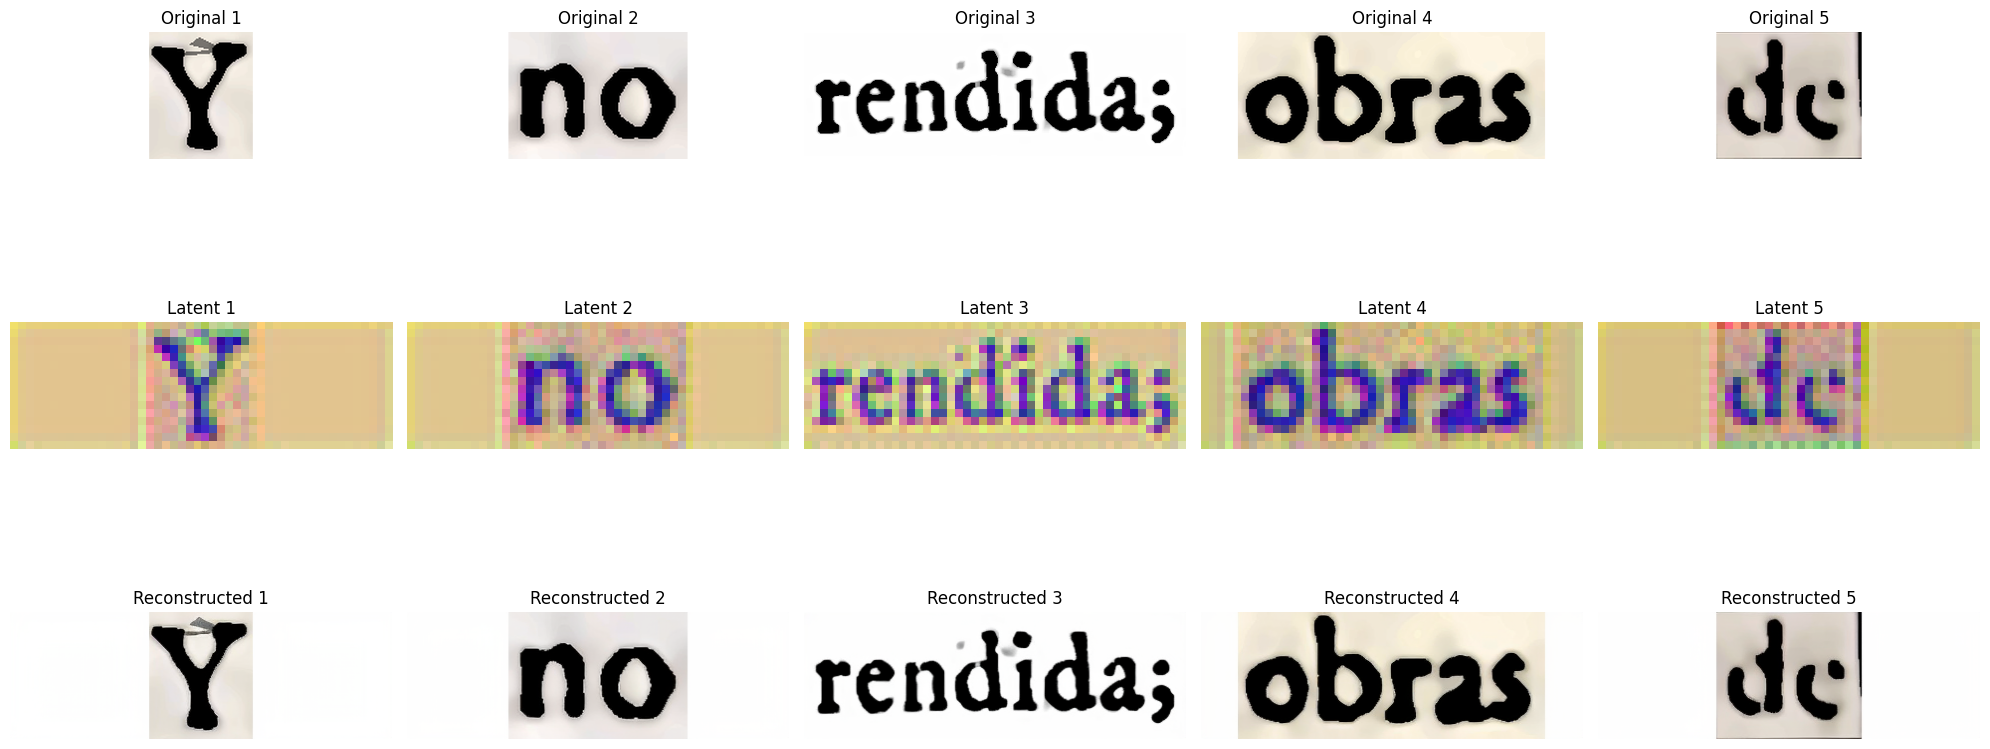

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import random
from pathlib import Path

# === Function to load and process an image ===
def process_image(image_path, vae, device="cuda"):
    image = Image.open(image_path).convert("RGB")
    original_np = np.array(image)  # For display

    # Preprocessing for VAE input
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # Scale to [-1, 1]
    ])
    pixel_values = preprocess(image).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]

    # Encode and decode using VAE
    with torch.no_grad():
        latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215
        recon = vae.decode(latents / 0.18215).sample  # Shape: [1, 3, H, W]

    # Prepare latent visualization
    latent = latents.squeeze(0).cpu()  # Shape: [C, H, W]
    latent_np = latent.permute(1, 2, 0).numpy()  # Shape: [H, W, C]

    # Use first 3 channels for RGB visualization
    if latent_np.shape[2] >= 3:
        latent_rgb = latent_np[:, :, :3]
    else:
        # Repeat channels if less than 3
        latent_rgb = np.repeat(latent_np[:, :, :1], 3, axis=2)

    # Normalize latent RGB for visualization
    latent_rgb = (latent_rgb - latent_rgb.min()) / (latent_rgb.max() - latent_rgb.min() + 1e-5)

    # Prepare reconstructed image for display
    recon_np = recon.squeeze(0).permute(1, 2, 0).cpu().numpy()
    recon_np = ((recon_np + 1.0) * 127.5).clip(0, 255).astype(np.uint8)

    return original_np, latent_rgb, recon_np

# === Main code to display multiple word images ===
def display_random_words(data_dir, vae, num_words=5, device="cuda"):
    # Ensure VAE is on the correct device
    vae = vae.to(device)

    # Get all image paths
    image_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_files.extend(list(Path(data_dir).glob(ext)))

    # Randomly select images
    if len(image_files) < num_words:
        print(f"Warning: Only {len(image_files)} images available, displaying all.")
        selected_images = image_files
    else:
        selected_images = random.sample(image_files, num_words)

    # Process each image
    results = []
    for img_path in selected_images:
        try:
            results.append(process_image(img_path, vae, device))
            print(f"Processed: {img_path.name}")
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")

    # Create figure with 3 rows (original, latent, reconstructed) and num_words columns
    num_processed = len(results)
    if num_processed == 0:
        print("No images were successfully processed.")
        return

    fig, axes = plt.subplots(3, num_processed, figsize=(num_processed * 4, 10))

    # Handle case with only one image (axes won't be 2D)
    if num_processed == 1:
        axes = axes.reshape(3, 1)

    # Display images
    for col, (original, latent, recon) in enumerate(results):
        # Original image
        axes[0, col].imshow(original)
        axes[0, col].set_title(f"Original {col+1}")
        axes[0, col].axis("off")

        # Latent representation
        axes[1, col].imshow(latent)
        axes[1, col].set_title(f"Latent {col+1}")
        axes[1, col].axis("off")

        # Reconstructed image
        axes[2, col].imshow(recon)
        axes[2, col].set_title(f"Reconstructed {col+1}")
        axes[2, col].axis("off")

    plt.tight_layout()
    plt.show()

# === Run the visualization ===
# Define the data directory
data_dir = "data/8_padded"  # Replace with your directory containing word images


# Make sure vae is moved to the correct device before using
# If you've already loaded the VAE, just move it to the device:
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = vae.to(device)

# Display 5 random word images
display_random_words(data_dir, vae, num_words=5, device=device)



### Embedding Text

In [ ]:
import pandas as pd
import torch
from transformers import CLIPTokenizer, CLIPTextModel
import os
from tqdm import tqdm

def encode_text_with_clip(texts, tokenizer, text_encoder, device="cuda", max_length=77):

    with torch.no_grad():
        # Tokenize texts
        text_inputs = tokenizer(
            texts,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt"
        ).to(device)

        # Get text embeddings
        text_embeddings = text_encoder(**text_inputs)[0]

    return text_embeddings

In [ ]:

# Load your dataframe with image paths and corresponding text
df = pd.read_csv("data/7_augmented_data/augmented_words.csv")

# Set up output directory for text embeddings
text_embeddings_dir = "data/9_encoded/text"
os.makedirs(text_embeddings_dir, exist_ok=True)

# Load CLIP models
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"  # You can use other CLIP variants

tokenizer = CLIPTokenizer.from_pretrained(model_id)
text_encoder = CLIPTextModel.from_pretrained(model_id).to(device)
text_encoder.eval()

# Process in batches to improve efficiency
batch_size = 64
num_samples = len(df)

for i in tqdm(range(0, num_samples, batch_size)):
    batch = df.iloc[i:min(i+batch_size, num_samples)]

    # Get texts for this batch
    texts = batch['label'].tolist()
    image_ids = batch['Image'].tolist()  # Assuming you have some ID to match images and text

    # Encode texts
    text_embeddings = encode_text_with_clip(texts, tokenizer, text_encoder, device)

    # Save each text embedding separately
    for j, image_id in enumerate(image_ids):
        embedding = text_embeddings[j]
        embedding_path = os.path.join(text_embeddings_dir, f"{image_id.replace('.png','.pt')}")
        torch.save(embedding, embedding_path)

print(f"Successfully encoded {num_samples} text samples and saved to {text_embeddings_dir}")


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

def load_fasttext_embeddings(file_path='wiki-news-300d-1M.vec'):

    word_vectors = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        # Skip first line (header)
        next(f)
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_vectors[word] = vector
    return word_vectors

def encode_text_with_fasttext(texts, fasttext_embeddings):

    embeddings = []
    for text in texts:
        # Lowercase and handle out-of-vocabulary words
        text = text.lower()

        # Get embedding (use zero vector if word not found)
        embedding = fasttext_embeddings.get(text, np.zeros(300))
        embeddings.append(embedding)

    return torch.FloatTensor(embeddings)

# Main embedding generation script
def generate_fasttext_embeddings(
    input_csv_path='data/7_augmented_data/augmented_words.csv',
    embeddings_file_path='models/wiki-news-300d-1M.vec',
    output_dir='data/9_encoded/fasttext'
):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Load dataframe
    df = pd.read_csv(input_csv_path)

    # Load FastText embeddings
    print("Loading FastText embeddings...")
    fasttext_embeddings = load_fasttext_embeddings(embeddings_file_path)

    # Process in batches
    batch_size = 64
    num_samples = len(df)

    # Embedding generation
    for i in tqdm(range(0, num_samples, batch_size)):
        batch = df.iloc[i:min(i+batch_size, num_samples)]

        # Get texts for this batch
        texts = batch['label'].tolist()
        image_ids = batch['Image'].tolist()

        # Encode texts
        text_embeddings = encode_text_with_fasttext(texts, fasttext_embeddings)

        # Save each text embedding separately
        for j, image_id in enumerate(image_ids):
            embedding = text_embeddings[j]
            embedding_path = os.path.join(output_dir, f"{image_id.replace('.png','.pt')}")
            torch.save(embedding, embedding_path)

    print(f"Successfully encoded {num_samples} text samples and saved to {output_dir}")


generate_fasttext_embeddings()

Loading FastText embeddings...


100%|██████████| 600/600 [00:57<00:00, 10.36it/s]

Successfully encoded 38376 text samples and saved to data/9_encoded/fasttext


# Model Building

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Splitting into train Val and test datasets

In [4]:
class ImageTextDataset(Dataset):
    def __init__(self,
                 image_latents_dir,
                 text_embeddings_dir,
                 dataframe,
                 image_col='Image',
                 text_col='label',
                 transform=None):

        self.image_latents_dir = Path(image_latents_dir)
        self.text_embeddings_dir = Path(text_embeddings_dir)
        self.df = dataframe
        self.transform = transform
        self.image_col = image_col

        # Create cleaned list of available pairs
        self.pairs = []

        # Get list of available latent files for quick lookup
        available_latents = set(f.stem for f in self.image_latents_dir.glob("*.pt"))
        available_text_embeddings = set(f.stem for f in self.text_embeddings_dir.glob("*.pt"))

        # Track statistics for reporting
        total_entries = len(self.df)
        missing_latents = 0
        missing_embeddings = 0

        # Create the pairs list
        for idx, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Building dataset"):
            # Get image filename without extension
            img_name = row[image_col]
            img_stem = Path(img_name).stem  # Remove extension

            # Check if both latent and text embedding exist
            if img_stem in available_latents and img_stem in available_text_embeddings:
                self.pairs.append({
                    'latent': f"{img_stem}.pt",
                    'text_embedding': f"{img_stem}.pt",
                    'original_image': img_name,
                    'text': row[text_col] if text_col in row else None
                })
            else:
                if img_stem not in available_latents:
                    missing_latents += 1
                if img_stem not in available_text_embeddings:
                    missing_embeddings += 1

        # Report statistics
        print(f"Dataset creation complete:")
        print(f"  - Total entries in DataFrame: {total_entries}")
        print(f"  - Valid pairs found: {len(self.pairs)}")
        print(f"  - Missing latent files: {missing_latents}")
        print(f"  - Missing text embeddings: {missing_embeddings}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        item = self.pairs[idx]

        # Load image latent with weights_only=True for security
        latent_path = self.image_latents_dir / item['latent']
        image_latent = torch.load(latent_path, map_location='cpu', weights_only=True).squeeze(0)

        # Load text embedding with weights_only=True for security
        text_path = self.text_embeddings_dir / item['text_embedding']
        text_embedding = torch.load(text_path, map_location='cpu', weights_only=True).unsqueeze(0)

        # Apply transforms if specified
        if self.transform:
            image_latent = self.transform(image_latent)

        return {
            'latent': image_latent,
            'text_embedding': text_embedding,
            'filename': item['original_image'],
            'text': item['text']
        }


def create_dataloaders(image_latents_dir, text_embeddings_dir, dataframe,
                     batch_size=8, train_size=0.9, val_size=0.1,
                     random_state=42, image_col='Image', text_col='label',pin_memory=True):
    
    # Create a single dataset
    full_dataset = ImageTextDataset(
        image_latents_dir=image_latents_dir,
        text_embeddings_dir=text_embeddings_dir,
        dataframe=dataframe,
        image_col=image_col,
        text_col=text_col
    )

    # Get indices for train-val split
    indices = list(range(len(full_dataset)))
    train_indices, val_indices = train_test_split(
        indices,
        train_size=train_size,
        test_size=val_size,
        random_state=random_state
    )

    # Create subset datasets using the indices
    from torch.utils.data import Subset
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    print(f"Training set: {len(train_dataset)} samples")
    print(f"Validation set: {len(val_dataset)} samples")

    # Create dataloaders with optimized settings
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=pin_memory,
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory,
    )

    return train_dataloader, val_dataloader

In [ ]:
df = pd.read_csv("/kaggle/input/augmented/augmented/augmented_words.csv")

# Directories containing encoded data
image_latents_dir = "/kaggle/input/augmented/augmented/images"
text_embeddings_dir = "/kaggle/input/augmented/augmented/fasttext"

# Create dataloaders with larger batch size for training efficiency
train_dataloader, val_dataloader = create_dataloaders(
    image_latents_dir=image_latents_dir,
    text_embeddings_dir=text_embeddings_dir,
    dataframe=df,
    batch_size=128,  # Increased from 8 for better efficiency
    train_size=0.9,
    val_size=0.1,
    random_state=42
)

## Building a diffusion model from scratch

### Visualising Denoising Process

In [ ]:
from model_utils import visualize_noise_schedule

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="squaredcos_cap_v2",
    clip_sample=False,
    prediction_type="v_prediction"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
latent_grid = visualize_noise_schedule(train_dataloader, noise_scheduler, device)

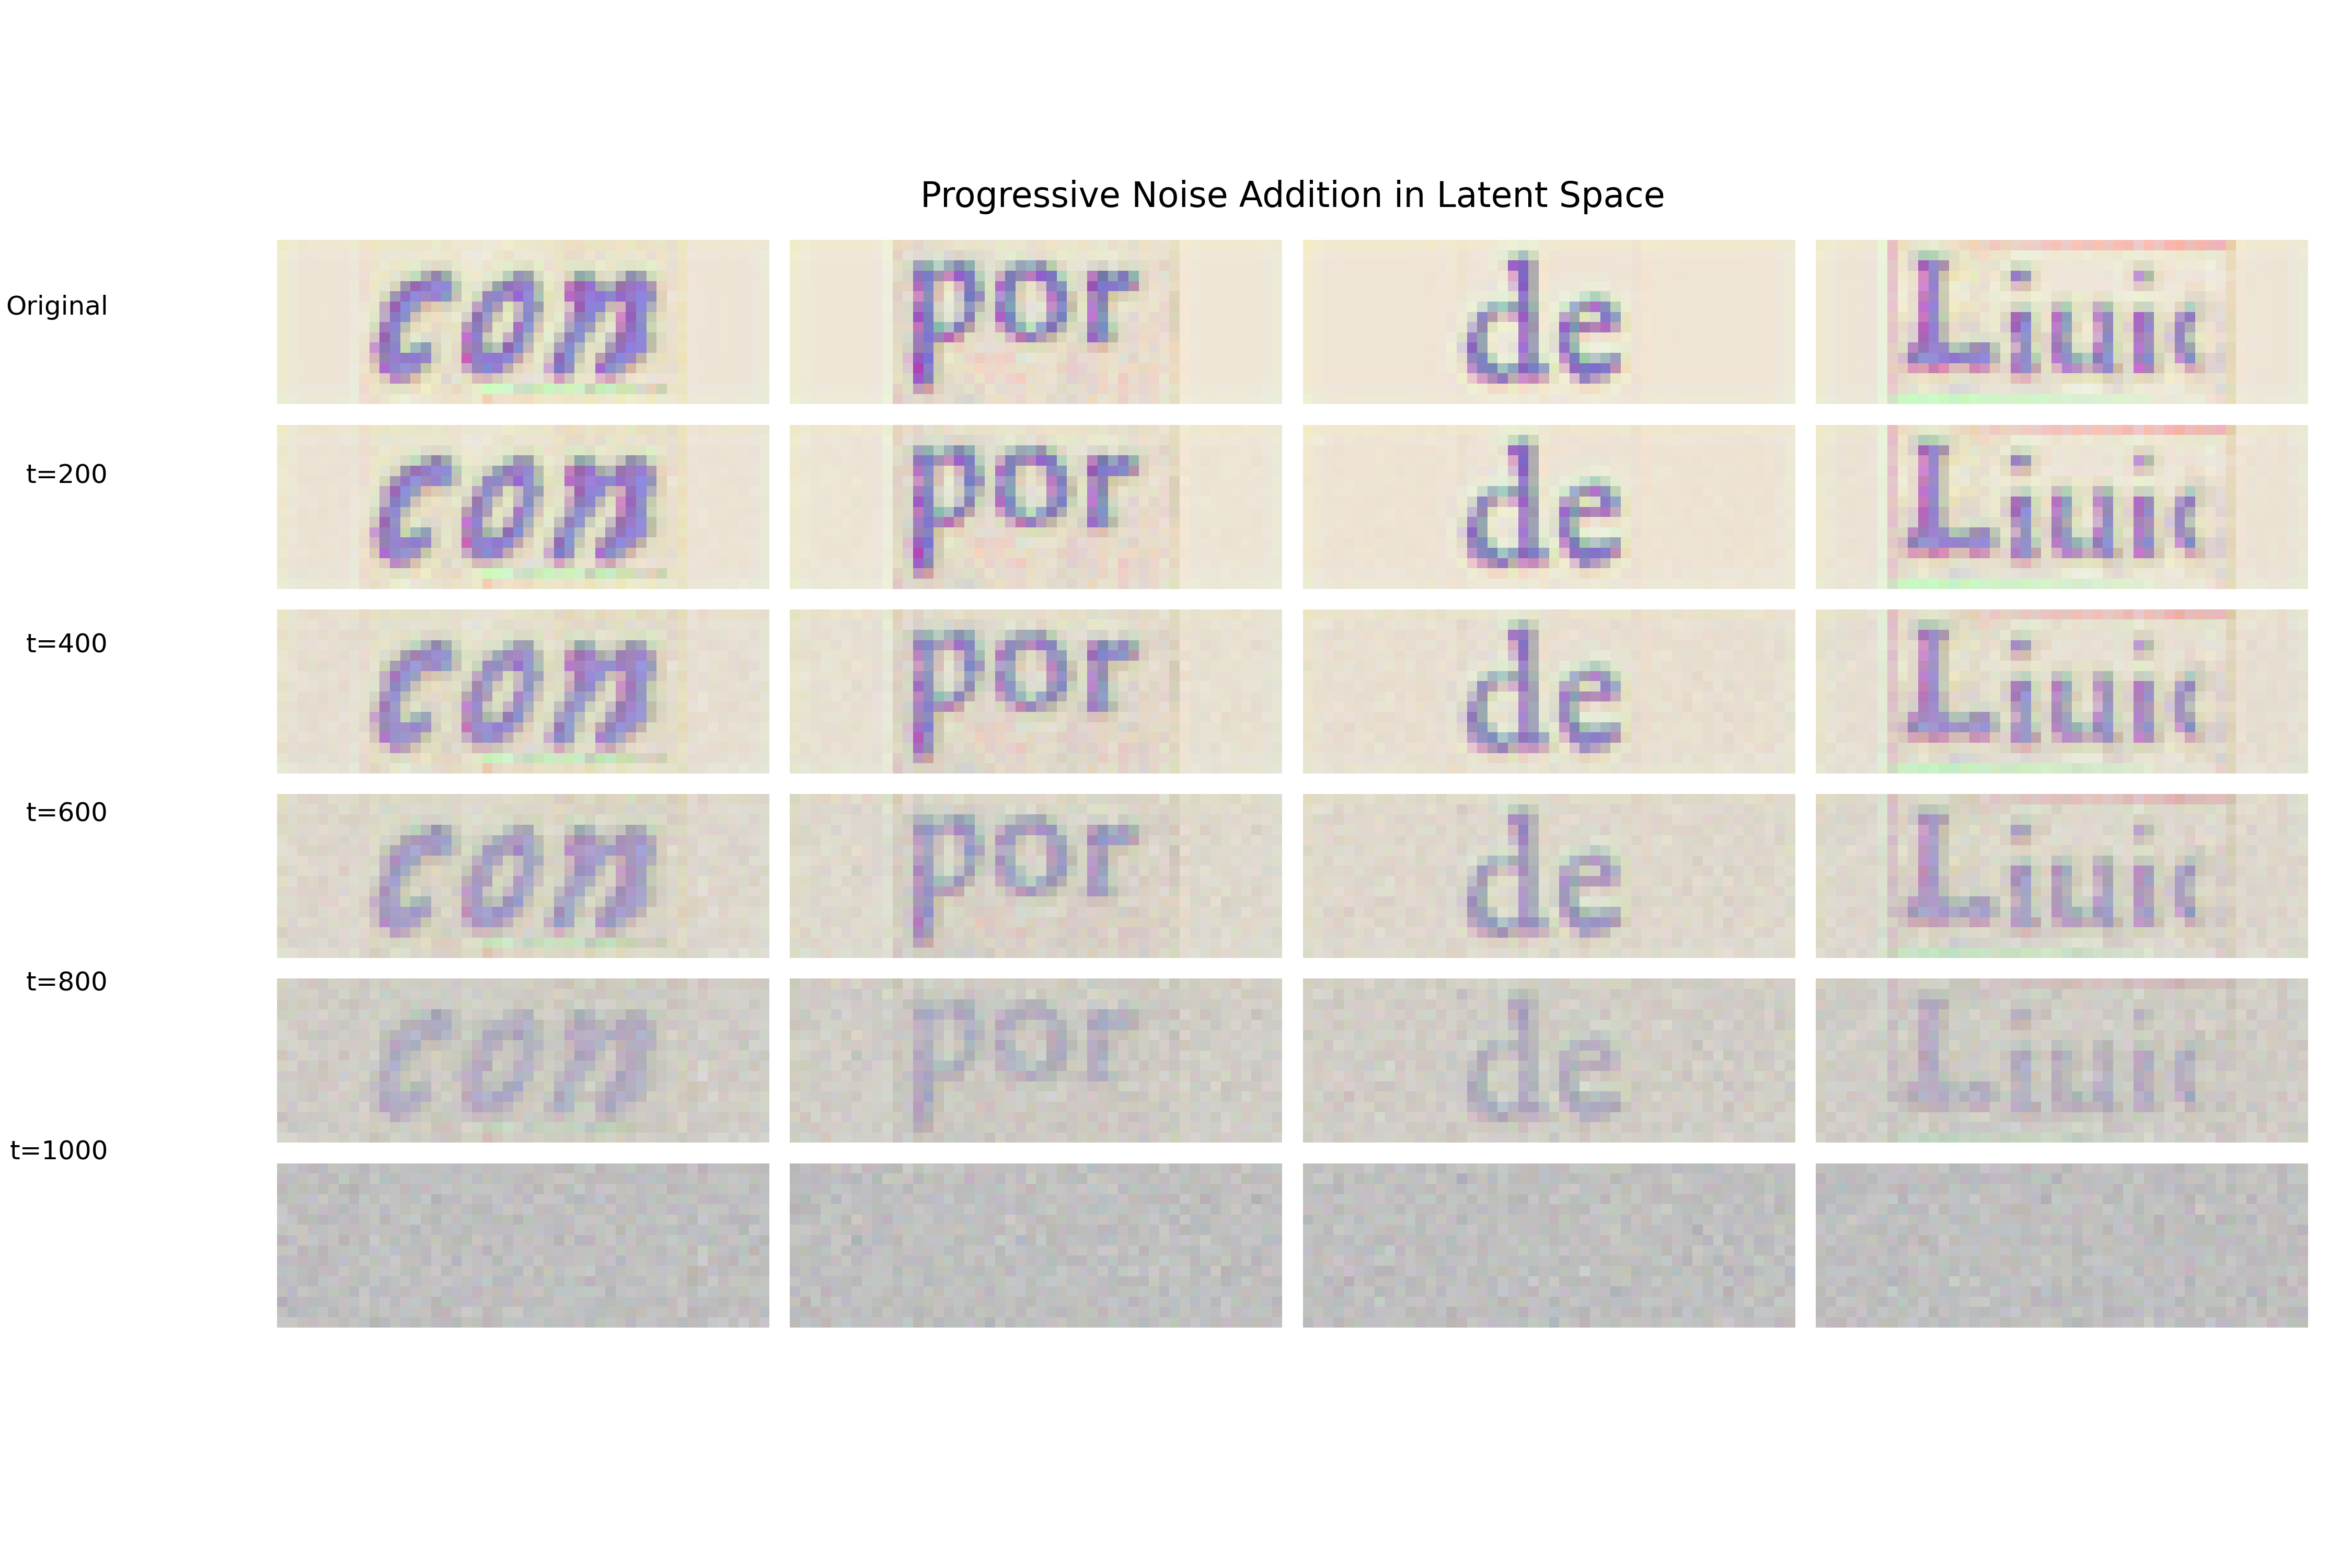

### Defining Model

In [ ]:
from model_utils import LightweightTextConditionedLDM

### Model Configration


In [8]:
# Modified noise scheduler configuration - improved beta scheduler
noise_scheduler_config = {
    "num_train_timesteps": 1000,
    "beta_start": 0.00085,
    "beta_end": 0.012,
    "beta_schedule": "squaredcos_cap_v2",  # Better quality results
    "clip_sample": False,
    "prediction_type": "v_prediction"  # Changed to v_prediction for better quality
}

unet_config = {
    # Maintain input dimensions for latents
    "sample_size": (16, 48),
    
    # Keep channels consistent with VAE
    "in_channels": 4,
    "out_channels": 4,
    
    # Keep layers per block at 2 for good feature representation
    "layers_per_block": 2,
    
    # Slightly reduce channel dimensions while keeping progressive growth pattern
    "block_out_channels": (96, 192, 384, 384),  # Reduced from (128, 256, 512, 512)
    
    # Keep cross-attention blocks for good text conditioning
    "down_block_types": (
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",  # Changed last block to regular DownBlock to save memory
    ),
    "up_block_types": (
        "UpBlock2D",  # Changed first block to regular UpBlock to save memory
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
    ),
    
    # Match text embedding dimension
    "cross_attention_dim": 300,
    
    # Reduce attention heads slightly but still more than original
    "attention_head_dim": 16,  # Reduced from 32
    
    # Reduce transformer layers to 1 for memory efficiency
    "transformer_layers_per_block": 1,  # Reduced from 2
    
    # Keep improved residual handling
    "resnet_time_scale_shift": "scale_shift",
    
    # Keep efficient projections
    "use_linear_projection": True,
    
    # Slightly reduce dropout
    "dropout": 0.1,
    
    # Use appropriate normalization
    "norm_num_groups": 32,
}

### Initializing Model

In [10]:
# Initialize your improved model with enhanced architecture
model = LightweightTextConditionedLDM(
    unet_config=unet_config,
    noise_scheduler_config=noise_scheduler_config,
    output_dir="ldm_output"
)

Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 210MB/s] 


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
Loaded training history: 50 epochs completed
Best validation loss: 0.19920512090126674 at epoch 46


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

### Visualising Model Architecture

In [11]:
from torchinfo import summary
def visualize_model_blocks(model, batch_size=4, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Extract model configuration
    sample_size = model.unet_config["sample_size"]
    in_channels = model.unet_config["in_channels"]
    cross_attention_dim = model.unet_config["cross_attention_dim"]

    # Create dummy inputs for the model
    latents_shape = (batch_size, in_channels, *sample_size)
    timesteps_shape = (batch_size,)
    text_embeddings_shape = (batch_size, 300, cross_attention_dim)

    # Get a high-level summary of the UNet model
    unet_summary = summary(
        model.unet,
        input_size=[
            latents_shape,
            timesteps_shape,
            text_embeddings_shape
        ],
        col_names=["output_size", "num_params"],
        depth=1,  # Only show top-level modules
        verbose=0
    )

    print("\n==== LightweightTextConditionedLDM Main Blocks ====")
    print(f"UNet Architecture - {type(model.unet).__name__}")
    print(f"Sample size: {sample_size}")
    print(f"Noise scheduler: {type(model.noise_scheduler).__name__}")

    return unet_summary

visualize_model_blocks(model)


==== LightweightTextConditionedLDM Main Blocks ====
UNet Architecture - UNet2DConditionModel
Sample size: (16, 48)
Noise scheduler: DDPMScheduler


Layer (type:depth-idx)                                            Output Shape              Param #
UNet2DConditionModel                                              [4, 4, 16, 48]            --
├─Timesteps: 1-1                                                  [4, 96]                   --
├─TimestepEmbedding: 1-2                                          [4, 384]                  185,088
├─SiLU: 1-3                                                       [4, 384]                  --
├─TimestepEmbedding: 1-4                                          --                        (recursive)
├─Conv2d: 1-5                                                     [4, 96, 16, 48]           3,552
├─ModuleList: 1-54                                                --                        (recursive)
├─SiLU: 1-7                                                       [4, 96, 16, 48]           --
├─ModuleList: 1-54                                                --                        (recursive)
├─SiLU: 1-

### Training the model

In [ ]:
# Train with all the enhancements
model.train(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=350,  # Train for a good number of epochs
    learning_rate=5e-5,  # Conservative base learning rate for OneCycleLR
    weight_decay=1e-2,  # Increased weight decay for better regularization
    gradient_accumulation_steps=4,
    save_model_epochs=50,
    validation_epochs=1,
    mixed_precision="fp16",
    resume_training=True,  # Start fresh with the new architecture
    ema_decay_start=0.9990,
    ema_decay_end=0.9999
)

## Testing the Model

### Preprocessing testing data

In [1]:
import os

input_root = "data/test/images"
transcripts_root = "data/test/transcripts"
output_root = "data/test/bounding_boxes//"

os.makedirs(output_root, exist_ok=True)

!python CRAFT-pytorch/test.py \
--trained_model=CRAFT-pytorch/weights/craft_mlt_25k.pth \
--result_folder={output_root} \
--test_folder={input_root} \
--text_threshold=0.8 \
--low_text=0.33 \
--link_threshold=0.5 \
--mag_ratio=1.2 \
--canvas_size=1800 \
--refiner_model=CRAFT-pytorch/weights/craft_refiner_CTW1500.pth \
--cuda=True


c:\Users\sarth\anaconda3\envs\imageGeneration\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarth\anaconda3\envs\imageGeneration\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
from utils import process_all_files

process_all_files(
    image_dir="data/test/images",
    bbox_dir="data/test/bounding_boxes",
    transcript_dir="data/test/transcripts",
    output_dir="data/test/mapped",
    tesseract_model=1,
    similarity_threshold=0.8
)

Processing files in data/test/images...
File book2_17: Found 146 words in transcript file, mapped 88 of 140 bounding boxes
File book2_22: Found 156 words in transcript file, mapped 95 of 142 bounding boxes
File book6_2: Found 112 words in transcript file, mapped 71 of 117 bounding boxes
File book6_4: Found 350 words in transcript file, mapped 183 of 310 bounding boxes
File book7_3: Found 429 words in transcript file, mapped 172 of 374 bounding boxes

Mapping complete. Model Used: 1. Processed 5 files. Total 1193 transcript words. Processed 1083 bounding boxes and successfully mapped 609 words.
0 files had no transcript


In [5]:
import pandas as pd
import os
from utils import extract_and_save_regions

image_root = "data/test/images"
aligned_root = "data/test/mapped"
output_root = "data/test/final/images"
os.makedirs(output_root, exist_ok=True)

df_records = []
global_index = 0

for image in os.listdir(aligned_root):
    image_path = os.path.join(image_root, image.replace("_mapped.txt", ".png"))
    aligned_path = os.path.join(aligned_root, image)

    results, global_index = extract_and_save_regions(image_path, aligned_path, output_root, global_index)
    df_records.extend(results)

df = pd.DataFrame(df_records, columns=["Image", "label"])

df.to_csv("data/test/final/words.csv", index=False)

In [21]:
target_height, target_width = 128,384  # Adjust based on your dataset
# Resize with aspect ratio preservation and pad

for image in os.listdir("data/test/final/images"):
    img = Image.open(f"data/test/final/images/{image}")
    processed_img = resize_and_pad(img, target_height, target_width, output_dir="data/test/final/images")

### Inference

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL, DDIMScheduler
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from diffusers.models import UNet2DConditionModel
from torch_fidelity import calculate_metrics
import lpips
import shutil
from scipy import linalg
from torchvision.transforms import functional as TF
from scipy.stats import wasserstein_distance
import cv2
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import datetime
import math
import io
import re
import sys
from contextlib import redirect_stdout


class LDMInference:
    def __init__(self, 
                model_path, 
                vae_path="stabilityai/sd-vae-ft-mse", 
                fasttext_path="wiki-news-300d-1M.vec",
                output_dir="comparison_results",
                device=None):
        # Set device
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Set up output directory
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "generated"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "comparisons"), exist_ok=True)
        
        # The expected image dimensions
        self.image_height = 128
        self.image_width = 384
        
        # The VAE scaling factor
        self.vae_scale_factor = 8
        
        # Calculate latent dimensions
        self.latent_height = self.image_height // self.vae_scale_factor
        self.latent_width = self.image_width // self.vae_scale_factor
        
        # Configure UNet with the same parameters used during training
        self.unet_config = {
                # Latent dimensions
                "sample_size": (self.latent_height, self.latent_width),  # (16, 48)
                
                # Keep channels consistent with VAE
                "in_channels": 4,
                "out_channels": 4,
                
                # Keep layers per block at 2 for good feature representation
                "layers_per_block": 2,
                
                # Channel dimensions
                "block_out_channels": (96, 192, 384, 384),
                
                # Cross-attention blocks
                "down_block_types": (
                    "CrossAttnDownBlock2D",
                    "CrossAttnDownBlock2D",
                    "CrossAttnDownBlock2D",
                    "DownBlock2D",
                ),
                "up_block_types": (
                    "UpBlock2D",
                    "CrossAttnUpBlock2D",
                    "CrossAttnUpBlock2D",
                    "CrossAttnUpBlock2D",
                ),
                
                # Match text embedding dimension
                "cross_attention_dim": 300,
                
                # Attention heads
                "attention_head_dim": 16,
                
                # Transformer layers
                "transformer_layers_per_block": 1,
                
                # Residual handling
                "resnet_time_scale_shift": "scale_shift",
                
                # Projections
                "use_linear_projection": True,
                
                # Dropout
                "dropout": 0.1,
                
                # Normalization
                "norm_num_groups": 32,
            }
        
        print(f"Image dimensions: {self.image_height}×{self.image_width}")
        print(f"Latent dimensions: {self.latent_height}×{self.latent_width}")
        
        # Load UNet model
        self.unet = UNet2DConditionModel(**self.unet_config).to(self.device)
        self.load_model(model_path)
        self.unet.eval()
        
        # Load VAE for encoding/decoding images
        print(f"Loading VAE from {vae_path}")
        self.vae = AutoencoderKL.from_pretrained(vae_path).to(self.device)
        self.vae.eval()
        
        # Set up the noise scheduler
        self.scheduler = DDIMScheduler(
            num_train_timesteps=1000,
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="squaredcos_cap_v2",
            clip_sample=False,
            prediction_type="v_prediction"
        )
        
        # Load FastText embeddings
        self.fasttext_embeddings = self.load_fasttext_embeddings(fasttext_path)
        print("FastText embeddings loaded")
        
        # Initialize LPIPS for perceptual similarity
        self.lpips_model = lpips.LPIPS(net='alex').to(self.device)
        
        # Image transformation pipeline
        self.transform = transforms.Compose([
            transforms.Resize((self.image_height, self.image_width)),
            transforms.ToTensor(),
        ])

    def load_fasttext_embeddings(self, file_path):
        print(f"Loading FastText embeddings from {file_path}")
        word_vectors = {}
        with open(file_path, 'r', encoding='utf-8') as f:
            # Skip first line (header)
            next(f)
            for line in tqdm(f, desc="Loading embeddings"):
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                word_vectors[word] = vector
        return word_vectors
        
            
    def encode_text(self, text):
        # Handle multi-word inputs
        words = text.lower().split()
        if len(words) > 1:
            # Average the embeddings of all words
            embeddings = [self.fasttext_embeddings.get(word, np.zeros(300)) for word in words]
            embedding = np.mean(embeddings, axis=0)
        else:
            # Get the embedding for a single word
            embedding = self.fasttext_embeddings.get(text.lower(), np.zeros(300))
        
        # Convert to tensor and reshape to match the expected format
        # Format: [batch_size, sequence_length, embedding_dim]
        embedding_tensor = torch.FloatTensor(embedding).unsqueeze(0)  # [1, 300]
        
        # Add sequence dimension to make it [1, 1, 300]
        embedding_tensor = embedding_tensor.unsqueeze(1).to(self.device)
        
        return embedding_tensor
    
    def load_model(self, path):
        """Load the trained model from checkpoint"""
        print(f"Loading UNet model from {path}")
        try:
            state_dict = torch.load(path, map_location=self.device)
            self.unet.load_state_dict(state_dict)
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise
    
    @torch.no_grad()
    def generate(self, 
                text, 
                num_images=1, 
                guidance_scale=2.5, 
                num_inference_steps=50, 
                seed=None,
                show_progress=True):
        
        # Set random seed for reproducibility if provided
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            
        # Encode the text prompt
        text_embedding = self.encode_text(text)
        
        # Set the scheduler timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        
        # Create an unconditional embedding for classifier-free guidance
        uncond_embedding = torch.zeros_like(text_embedding)
        
        # Combine the embeddings for classifier-free guidance
        text_embeddings = torch.cat([uncond_embedding, text_embedding])
        
        # Get latent dimensions from unet config sample_size
        latent_height, latent_width = self.unet_config["sample_size"]
        
        # Create initial random latents
        latents_shape = (num_images, 4, latent_height, latent_width)
        
        # Initialize with random noise
        latents = torch.randn(latents_shape, device=self.device)
        
        # Loop through the diffusion process (denoising)
        timesteps_iter = tqdm(self.scheduler.timesteps, desc="Generating image") if show_progress else self.scheduler.timesteps
        for i, t in enumerate(timesteps_iter):
            # Expand latents for classifier-free guidance
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
            
            # For each timestep
            timesteps = torch.tensor([t] * latent_model_input.shape[0], device=self.device)
            
            # Predict the noise residual
            noise_pred = self.unet(latent_model_input, timesteps, text_embeddings).sample
            
            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            # Compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample
        
        # Decode the latent representation to images
        # Use the scaling factor appropriate for the VAE
        latents = 1 / 0.18215 * latents
        
        with torch.no_grad():
            images = self.vae.decode(latents).sample
        
        # Process images
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        
        # Convert to PIL images
        pil_images = []
        for image in images:
            image_pil = Image.fromarray((image * 255).round().astype("uint8"))
            pil_images.append(image_pil)
            
        return pil_images

    
    def calculate_lpips(self, img1, img2):
        """Calculate LPIPS perceptual similarity between two images"""
        # Ensure both images are resized to the expected model dimensions
        img1 = img1.resize((self.image_width, self.image_height))
        img2 = img2.resize((self.image_width, self.image_height))
        
        # Convert PIL images to tensors in [-1, 1] range
        img1_tensor = transforms.ToTensor()(img1).unsqueeze(0).to(self.device) * 2 - 1
        img2_tensor = transforms.ToTensor()(img2).unsqueeze(0).to(self.device) * 2 - 1
        
        # Calculate LPIPS
        with torch.no_grad():
            lpips_score = self.lpips_model(img1_tensor, img2_tensor).item()
        
        return lpips_score
    
    def calculate_mse(self, img1, img2):
        """Calculate Mean Squared Error between two images"""
        # Ensure both images are resized to the expected model dimensions
        img1 = img1.resize((self.image_width, self.image_height))
        img2 = img2.resize((self.image_width, self.image_height))
        
        img1_array = np.array(img1).astype(np.float32) / 255.0
        img2_array = np.array(img2).astype(np.float32) / 255.0
            
        return mean_squared_error(img1_array.flatten(), img2_array.flatten())
    
    def calculate_ssim(self, img1, img2):
        """Calculate Structural Similarity Index between two images"""
        # Ensure both images are resized to the expected model dimensions
        img1 = img1.resize((self.image_width, self.image_height))
        img2 = img2.resize((self.image_width, self.image_height))
        
        img1_array = np.array(img1)
        img2_array = np.array(img2)
        
        # Calculate SSIM for each channel and take the mean
        ssim_score = ssim(img1_array, img2_array, channel_axis=2, data_range=255)
        return ssim_score
    
    def get_statistics(self, img):
        """Calculate statistics for a simplified FID-like metric"""
        # Resize image to ensure consistent dimensions
        img = img.resize((self.image_width, self.image_height))
        img_array = np.array(img)
        
        # Convert to grayscale
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:  # RGB image
            img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:  # Already grayscale
            img_gray = img_array
        
        # Normalize pixel values
        img_norm = img_gray.astype(np.float32) / 255.0
        
        # Compute mean and standard deviation
        mu = np.mean(img_norm)
        sigma = np.std(img_norm)
        
        return mu, sigma
    
    def calculate_fid_like(self, real_img, gen_img):

        try:
            # Get statistics
            mu1, sigma1 = self.get_statistics(real_img)
            mu2, sigma2 = self.get_statistics(gen_img)
            
            # Calculate a simple distance metric
            # Using squared difference of means and variances
            mean_diff_squared = (mu1 - mu2) ** 2
            var_diff_squared = (sigma1 - sigma2) ** 2
            
            # Simple FID-like score
            fid_like = mean_diff_squared + var_diff_squared
            
            return float(fid_like)
        except Exception as e:
            print(f"Error in FID-like calculation: {e}")
            return 1000.0  # Return a high value to indicate error

    def run_evaluation(self, test_df, batch_size=16, guidance_scale=7.5, num_inference_steps=50, seed=42):

        # Check that the dataframe has the required columns
        required_columns = ['Image', 'label']
        if not all(col in test_df.columns for col in required_columns):
            raise ValueError(f"DataFrame must contain columns: {required_columns}")
        
        # Initialize results as a list to collect dictionaries
        results_list = []
        
        # Set seed for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        # Create a single progress bar for the entire process
        total_samples = len(test_df)
        progress_bar = tqdm(total=total_samples, desc="Evaluating samples")
        
        # Process in batches to avoid memory issues
        num_batches = (total_samples + batch_size - 1) // batch_size
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, total_samples)
            
            batch_df = test_df.iloc[start_idx:end_idx].reset_index(drop=True)
            
            # Process each sample in the batch
            for idx, row in enumerate(batch_df.itertuples()):
                label = row.label
                real_image_path = row.Image
                
                # Load real image
                real_image = Image.open(real_image_path).convert('RGB')
                if real_image is None:
                    print(f"Skipping sample with label '{label}' due to image loading error")
                    progress_bar.update(1)
                    continue
                
                try:
                    # Generate image from label (no progress bar for generation)
                    generated_images = self.generate(
                        text=label,
                        num_images=1,
                        guidance_scale=guidance_scale,
                        num_inference_steps=num_inference_steps,
                        seed=seed + start_idx + idx,  # Use different seed for each sample
                        show_progress=False  # Don't show progress for individual generations
                    )
                    
                    gen_image = generated_images[0]
                    
                    # Save generated image
                    gen_image_filename = f"{label.replace(' ', '_')}_{start_idx + idx}.png"
                    gen_image_path = os.path.join(self.output_dir, "generated", gen_image_filename)
                    gen_image.save(gen_image_path)
                    
                    # Create comparison image
                    comparison = Image.new('RGB', (2 * self.image_width, self.image_height))
                    comparison.paste(real_image, (0, 0))
                    comparison.paste(gen_image, (self.image_width, 0))
                    
                    # Add text labels
                    comparison_filename = f"compare_{label.replace(' ', '_')}_{start_idx + idx}.png"
                    comparison_path = os.path.join(self.output_dir, "comparisons", comparison_filename)
                    comparison.save(comparison_path)
                    
                    # Calculate metrics
                    lpips_score = self.calculate_lpips(real_image, gen_image)
                    mse = self.calculate_mse(real_image, gen_image)
                    ssim_score = self.calculate_ssim(real_image, gen_image)
                    fid_like = self.calculate_fid_like(real_image, gen_image)
                    
                    # Add to results as a dictionary
                    results_list.append({
                        'label': label,
                        'real_image_path': real_image_path,
                        'generated_image_path': gen_image_path,
                        'comparison_path': comparison_path,
                        'lpips_score': lpips_score,
                        'mse': mse,
                        'ssim': ssim_score,
                        'fid_like': fid_like
                    })
                except Exception as e:
                    print(f"Error processing sample {label}: {e}")
                finally:
                    # Update progress regardless of success or failure
                    progress_bar.update(1)
            
            # Save intermediate results - convert list to DataFrame
            interim_results_df = pd.DataFrame(results_list)
            interim_results_path = os.path.join(self.output_dir, "interim_results.csv")
            interim_results_df.to_csv(interim_results_path, index=False)
        
        # Close the progress bar
        progress_bar.close()
        
        # Create the final results DataFrame
        results_df = pd.DataFrame(results_list)
        
        # Calculate average metrics
        avg_metrics = {
            'avg_lpips': results_df['lpips_score'].mean(),
            'avg_mse': results_df['mse'].mean(),
            'avg_ssim': results_df['ssim'].mean(),
            'avg_fid_like': results_df['fid_like'].mean()
        }
        
        print("\nAverage Metrics:")
        for metric, value in avg_metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Save final results
        final_results_path = os.path.join(self.output_dir, "evaluation_results.csv")
        results_df.to_csv(final_results_path, index=False)
        
        # Save summary metrics
        with open(os.path.join(self.output_dir, "summary_metrics.txt"), 'w') as f:
            f.write("Summary Metrics\n")
            f.write("==============\n\n")
            for metric, value in avg_metrics.items():
                f.write(f"{metric}: {value:.4f}\n")
        
        # Create visualization of best and worst matches
        self.visualize_best_worst_matches(results_df)
        
        return results_df, avg_metrics
    
    def visualize_best_worst_matches(self, results_df, metric='ssim', n=5):
        """
        Create visualizations of the best and worst matches according to a specific metric
        
        Args:
            results_df: DataFrame with results
            metric: Metric to sort by ('ssim', 'lpips_score', 'mse', or 'fid_like')
            n: Number of samples to show
        """+
        if len(results_df) == 0:
            print("No results to visualize")
            return
        
        # Determine sort order based on metric (for SSIM, higher is better; for others, lower is better)
        ascending = metric != 'ssim'
        
        # Sort by the specified metric
        sorted_df = results_df.sort_values(by=metric, ascending=ascending)
        
        # Get the best and worst n samples
        best_samples = sorted_df.head(n)
        worst_samples = sorted_df.tail(n)
        
        # Create visualizations
        self._create_comparison_grid(best_samples, f"best_{metric}", n)
        self._create_comparison_grid(worst_samples, f"worst_{metric}", n)
    
    def _create_comparison_grid(self, samples_df, title, n):
        """Helper function to create a grid of comparison images"""
        samples = min(len(samples_df), n)
        if samples == 0:
            return
        
        # Handle case with a single sample differently
        if samples == 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 3))
            
            # Get the single row
            row = samples_df.iloc[0]
            
            # Load images
            real_img = Image.open(row['real_image_path']).convert('RGB')
            gen_img = Image.open(row['generated_image_path']).convert('RGB')
            
            # Resize to expected dimensions
            real_img = real_img.resize((self.image_width, self.image_height))
            gen_img = gen_img.resize((self.image_width, self.image_height))
            
            # Display images
            axes[0].imshow(real_img)
            axes[0].set_title(f"Real: {row['label']}")
            axes[0].axis('off')
            
            axes[1].imshow(gen_img)
            metrics_text = f"LPIPS: {row['lpips_score']:.3f}, MSE: {row['mse']:.3f}\nSSIM: {row['ssim']:.3f}, FID-like: {row['fid_like']:.3f}"
            axes[1].set_title(f"Generated: {metrics_text}")
            axes[1].axis('off')
        else:
            # Create subplots grid
            fig, axes = plt.subplots(samples, 2, figsize=(10, samples * 3))
            
            for i, (_, row) in enumerate(samples_df.iterrows()):
                if i >= samples:
                    break
                    
                # Load images
                real_img = Image.open(row['real_image_path']).convert('RGB')
                gen_img = Image.open(row['generated_image_path']).convert('RGB')
                
                # Resize to expected dimensions
                real_img = real_img.resize((self.image_width, self.image_height))
                gen_img = gen_img.resize((self.image_width, self.image_height))
                
                # Display images
                axes[i][0].imshow(real_img)
                axes[i][0].set_title(f"Real: {row['label']}")
                axes[i][0].axis('off')
                
                axes[i][1].imshow(gen_img)
                metrics_text = f"LPIPS: {row['lpips_score']:.3f}, MSE: {row['mse']:.3f}\nSSIM: {row['ssim']:.3f}, FID-like: {row['fid_like']:.3f}"
                axes[i][1].set_title(f"Generated: {metrics_text}")
                axes[i][1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"{title}_comparisons.png"), dpi=150, bbox_inches='tight')
        plt.close(fig)
        
    def compute_batch_fid(self, real_images_dir, generated_images_dir, subset_size=None):

        print(f"Computing batch FID between {real_images_dir} and {generated_images_dir}")
        
        # Create temporary directories with symlinks if using a subset
        if subset_size is not None:
            import tempfile
            import random
            import shutil
            
            # Create temporary directories
            real_temp_dir = tempfile.mkdtemp()
            gen_temp_dir = tempfile.mkdtemp()
            
            try:
                # Get list of image files
                real_files = [f for f in os.listdir(real_images_dir) 
                             if f.endswith(('.png', '.jpg', '.jpeg'))]
                gen_files = [f for f in os.listdir(generated_images_dir) 
                            if f.endswith(('.png', '.jpg', '.jpeg'))]
                
                # Make sure we have enough files
                if len(real_files) < subset_size or len(gen_files) < subset_size:
                    print(f"Warning: Not enough images for subset (real: {len(real_files)}, gen: {len(gen_files)})")
                    subset_size = min(len(real_files), len(gen_files))
                
                # Randomly select subset_size files (or all if fewer)
                real_subset = random.sample(real_files, min(subset_size, len(real_files)))
                gen_subset = random.sample(gen_files, min(subset_size, len(gen_files)))
                
                print(f"Using {len(real_subset)} real images and {len(gen_subset)} generated images for FID calculation")
                
                for f in real_subset:
                    src = os.path.join(real_images_dir, f)
                    dst = os.path.join(real_temp_dir, f)
                    shutil.copy2(src, dst)
                        
                for f in gen_subset:
                    src = os.path.join(generated_images_dir, f)
                    dst = os.path.join(gen_temp_dir, f)
                    shutil.copy2(src, dst)
                
                # Calculate FID on the subset
                try:
                    # Redirect stdout to capture the FID value
                    f_output = io.StringIO()
                    with redirect_stdout(f_output):
                        metrics = calculate_metrics(
                            input1=real_temp_dir,
                            input2=gen_temp_dir,
                            cuda=torch.cuda.is_available(),
                            fid=True,
                            verbose=True
                        )
                    
                    # Get the output
                    output = f_output.getvalue()
                    
                    # First try to get FID from metrics
                    fid_score = metrics.get('fid', float('nan'))
                    
                    # If FID is nan, try to extract it from the output
                    if math.isnan(fid_score):
                        fid_match = re.search(r'Frechet Inception Distance: (\d+\.\d+)', output)
                        if fid_match:
                            fid_score = float(fid_match.group(1))
                            print(f"Extracted FID score from output: {fid_score:.4f}")
                        else:
                            print("Could not extract FID score from output")
                            print("Output was:", output)
                    
                except Exception as e:
                    print(f"Error calculating FID: {e}")
                    fid_score = float('nan')
                
            finally:
                # Clean up temporary directories
                shutil.rmtree(real_temp_dir)
                shutil.rmtree(gen_temp_dir)
                
        else:
            # Calculate FID on all images
            try:
                # Redirect stdout to capture the FID value
                f_output = io.StringIO()
                with redirect_stdout(f_output):
                    metrics = calculate_metrics(
                        input1=real_images_dir,
                        input2=generated_images_dir,
                        cuda=torch.cuda.is_available(),
                        fid=True,
                        verbose=True
                    )
                
                # Get the output
                output = f_output.getvalue()
                
                # First try to get FID from metrics
                fid_score = metrics.get('fid', float('nan'))
                
                # If FID is nan, try to extract it from the output
                if math.isnan(fid_score):
                    fid_match = re.search(r'Frechet Inception Distance: (\d+\.\d+)', output)
                    if fid_match:
                        fid_score = float(fid_match.group(1))
                        print(f"Extracted FID score from output: {fid_score:.4f}")
                    else:
                        print("Could not extract FID score from output")
                        print("Output was:", output)
                
            except Exception as e:
                print(f"Error calculating FID: {e}")
                fid_score = float('nan')
            
        return fid_score


In [20]:
# Example usage
if __name__ == "__main__":
    # Load test dataframe
    test_df = pd.read_csv('data/test/final/words.csv')
    test_df['Image'] = test_df['Image'].apply(lambda x: os.path.join('data/test/final/images', x))
    
    # Initialize the model
    model = LDMInference(
        model_path="ldm_output/min_val_ema_model.pt",
        vae_path="stabilityai/sd-vae-ft-mse",
        fasttext_path="models/wiki-news-300d-1M.vec",
        output_dir="evaluation_results"
    )
    
    # Run evaluation
    results, metrics = model.run_evaluation(
        test_df,
        batch_size=16,
        guidance_scale=8.5,
        num_inference_steps=250,
        # seed=42
    )

Using device: cuda
Image dimensions: 128×384
Latent dimensions: 16×48
Loading UNet model from ldm_output/min_val_ema_model.pt
Model loaded successfully
Loading VAE from stabilityai/sd-vae-ft-mse
Loading FastText embeddings from models/wiki-news-300d-1M.vec


Loading embeddings: 0it [00:00, ?it/s]

FastText embeddings loaded
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\sarth\anaconda3\envs\imageGeneration\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarth\anaconda3\envs\imageGeneration\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\sarth\anaconda3\envs\imageGeneration\lib\site-packages\lpips\weights\v0.1\alex.pth


Evaluating samples:   0%|          | 0/609 [00:00<?, ?it/s]


Average Metrics:
avg_lpips: 0.8223
avg_mse: 0.2922
avg_ssim: 0.0565
avg_fid_like: 0.1151


In [ ]:
# Create directories for FID computation
real_images_fid_dir = "evaluation_results/real_images_for_fid"
os.makedirs(real_images_fid_dir, exist_ok=True)

# First, clear the directory to ensure clean state
for file in os.listdir(real_images_fid_dir):
    file_path = os.path.join(real_images_fid_dir, file)
    if os.path.isfile(file_path):
        os.remove(file_path)

# Copy and preprocess real images to ensure they match the expected format
print("Preparing real images for FID calculation...")
for idx, row in test_df.iterrows():
    try:
        # Use a consistent naming scheme that avoids special characters
        img_name = f"real_{idx:04d}.png"
        dest_path = os.path.join(real_images_fid_dir, img_name)
        
        # Load, preprocess, and save the image with the right dimensions
        img = Image.open(row['Image']).convert('RGB')
        if img is not None:
            img.save(dest_path)
    except Exception as e:
        print(f"Error processing image {row['Image']}: {e}")

# Create directory for generated images specifically for FID
gen_images_fid_dir = "evaluation_results/generated_images_for_fid"
os.makedirs(gen_images_fid_dir, exist_ok=True)

# Clear the directory
for file in os.listdir(gen_images_fid_dir):
    file_path = os.path.join(gen_images_fid_dir, file)
    if os.path.isfile(file_path):
        os.remove(file_path)

# Copy and preprocess generated images
print("Preparing generated images for FID calculation...")
gen_files = [f for f in os.listdir(os.path.join(model.output_dir, "generated")) 
             if f.endswith(('.png', '.jpg', '.jpeg'))]

for idx, file in enumerate(gen_files):
    try:
        # Use a consistent naming scheme
        img_name = f"gen_{idx:04d}.png"
        src_path = os.path.join(model.output_dir, "generated", file)
        dest_path = os.path.join(gen_images_fid_dir, img_name)
        
        # Load, ensure dimensions, and save
        img = Image.open(src_path).convert('RGB')
        img = img.resize((model.image_width, model.image_height))
        img.save(dest_path)
    except Exception as e:
        print(f"Error processing generated image {file}: {e}")

# Verify both directories have images
real_count = len([f for f in os.listdir(real_images_fid_dir) if f.endswith('.png')])
gen_count = len([f for f in os.listdir(gen_images_fid_dir) if f.endswith('.png')])

print(f"Images prepared for FID calculation: {real_count} real, {gen_count} generated")

# Calculate FID with better error handling
try:
    # For most reliable results, use at least 50 images for FID calculation
    subset_size = min(50, real_count, gen_count)
    
    if subset_size < 10:
        print("Warning: Very few images available for FID calculation (less than 10)")
        print("Results may not be statistically significant")
    
    print(f"Computing FID on {subset_size} images from each set...")
    
    # Redirect standard output to capture printed FID value
    f = io.StringIO()
    with redirect_stdout(f):
        metrics_dict = calculate_metrics(
            input1=real_images_fid_dir,
            input2=gen_images_fid_dir,
            cuda=torch.cuda.is_available(),
            fid=True,
            verbose=True,
            samples_find_deep=True,
            samples_find="*.png",
            samples_limit=subset_size,
            batch_size=8
        )
    
    # Get the output text
    output = f.getvalue()
    
    # Try to get FID score from metrics dict first
    fid_score = metrics_dict.get('fid', float('nan'))
    
    # If that didn't work, try to parse it from the output text
    if math.isnan(fid_score):
        fid_match = re.search(r'Frechet Inception Distance: (\d+\.\d+)', output)
        if fid_match:
            fid_score = float(fid_match.group(1))
            print(f"Extracted FID score from output: {fid_score:.4f}")
        else:
            print("Could not extract FID from output. Output was:")
            print(output)
    
    if not math.isnan(fid_score):
        print(f"FID calculation successful. Score: {fid_score:.4f}")
    else:
        print("Failed to extract a valid FID score.")
        
except Exception as e:
    import traceback
    print(f"Error calculating FID: {e}")
    traceback.print_exc()
    fid_score = float('nan')
    
    # Try alternative method if torch-fidelity fails
    try:
        print("Attempting FID calculation with clean-fid library...")
        try:
            from cleanfid import fid
            
            # Calculate FID using clean-fid
            score = fid.compute_fid(
                real_images_fid_dir, 
                gen_images_fid_dir,
                mode="clean",
                device=model.device
            )
            
            print(f"Clean-FID calculation successful. Score: {score:.4f}")
            fid_score = score
        except ImportError:
            print("clean-fid library not found. Please install with 'pip install clean-fid' for alternative FID calculation.")
    except Exception as e:
        print(f"Error calculating FID with alternative method: {e}")
        fid_score = float('nan')

# Save FID score
with open(os.path.join(model.output_dir, "fid_score.txt"), 'w') as f:
    f.write(f"FID Score: {fid_score:.4f}\n")
    f.write(f"Number of real images used: {real_count}\n")
    f.write(f"Number of generated images used: {gen_count}\n")
    f.write(f"Date/time: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"Batch FID score: {fid_score:.4f}")

Preparing real images for FID calculation...
Preparing generated images for FID calculation...
Images prepared for FID calculation: 609 real, 609 generated
Computing FID on 50 images from each set...


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples recursively in "evaluation_results/real_images_for_fid" with extensions png,jpg,jpeg
Found 609 samples
Processing samples                                                         
Extracting statistics from input 2
Looking for samples recursively in "evaluation_results/generated_images_for_fid" with extensions png,jpg,jpeg
Found 609 samples
Processing samples                                                         


Could not extract FID from output. Output was:

Failed to extract a valid FID score.
Batch FID score: nan


Frechet Inception Distance: 415.1817656189405


## Finetuning Stable Diffusion

In [ ]:
# !nvidia-smi

In [ ]:
# !accelerate launch train_text_to_image_lora.py \
#     --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
#     --train_data_dir="training_data" \
#     --image_column="image" \
#     --caption_column="text" \
#     --resolution=512 \
#     --train_batch_size=1 \
#     --gradient_accumulation_steps=4 \
#     --learning_rate=1e-4 \
#     --lr_scheduler="constant" \
#     --lr_warmup_steps=0 \
#     --max_train_steps=2000 \
#     --checkpointing_steps=50 \
#     --output_dir="./output" \
#     --rank=4 \
#     --seed=42 \
#     --enable_xformers_memory_efficient_attention \
#     --logging_dir="./logs" \
#     --mixed_precision="no"

In [ ]:
# from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
# import torch

# base_model = "runwayml/stable-diffusion-v1-5"
# lora_path = "./output"  # or wherever your LoRA checkpoint is

# pipe = StableDiffusionPipeline.from_pretrained(
#     base_model,
#     torch_dtype=torch.float16,
#     safety_checker=None,  # optional to avoid filtering
# ).to("cuda")

# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.load_lora_weights(lora_path)

# # ✨ Improved style-aware prompt
# transcript = (
#     "al illuustrissimo señor"
#     "don alonso perez"
#     "de guzman el bueno"
#     "patriarcha de las indias"
#     "arzobispo de tyro limosnero mayor del rey"
#     "nuestro señor don felipe iu el grande rey de"
#     "las españas del consejo de su magestad y iuez"
#     "eclesiastico ordinario de su real capilla casa"
#     "y corte"
#     "segunda uez illustrissimo señor salen de"
#     "la estampa estos documentos politicos y morales"
#     "para formar un principe perfecto y ministros aju"
#     "stados por auerse despachado en tiempo breue la im"
#     "presion primera helos añadido de nueuo y exornado"
#     "con estampas de emblemas que con mas halago de los ojos pongan a"
#     "la uista las enseñanzas consagre a la magestad catolica de nuestro"
#     "monarca la primera uez este libro y para que buelua mejorado a sus"
#     "reales manos le pongo en las usi de quien le admitira con los"
#     "agrados que tienen a su magestad merecidos sus grandes y conti"
#     "nuados seruicios como si no uuiera usi heredado de sus excellenti"
#     "simos progenitores ser guzman el bueno con sus acciones ha gran"

# )

# prompt = (
#     "A high-resolution Renaissance printed manuscript page, full of ornate Latin text. "
#     "Old ink, imperfect print, antique paper, 1600s typography style. The text reads: "
#     + transcript
# )

# # Generate the image
# image = pipe(prompt, num_inference_steps=50).images[0]
# image.save("test_output.png")
